# Expenditure Change Behaviour PREDICTION MODEL

# Predicting whether a person is likely to spend less, more or same when there is a sudden change in their income based on the factors like their working status (How many hours they are working), Region(where they live), and Household Income (Which class of income they fall). 

In [1]:
# Importing Necessary libraries 

import numpy as np
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

# Changing Working Directory
%cd C:\Users\dell\OneDrive - UWE Bristol\4. Interdiciplinary Group Project\Assignment\ML prediction

C:\Users\dell\OneDrive - UWE Bristol\4. Interdiciplinary Group Project\Assignment\ML prediction


In [2]:
# Opening the file generated with specific columns needed for creating model

boe_data = pd.read_csv('BOE_Prediction.csv')
boe_data


,identifier,age,WorkingStatus,qincome(household income),Region (NEW),Region,o12q5(annual spending changes)
0,22007620,23,1,10,NaN,NaN,NaN
1,22238715,22,1,9,NaN,NaN,NaN
2,20404925,59,8,12,NaN,NaN,NaN
3,21839916,21,7,1,NaN,NaN,NaN
4,23091998,24,1,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...
53119,1491543354,48,1,0,Wales,10.0,NaN
53120,1803085531,61,9,0,Scotland,11.0,NaN
53121,1491736235,40,1,0,South West,3.0,NaN
53122,1490608952,43,9,0,Scotland,11.0,NaN


# Data Cleaning

In [3]:
# Dropping Unncessary columns

boe_data.drop(['identifier'],1,inplace=True)
boe_data.drop(['Region (NEW)'],1,inplace=True)
boe_data.drop(['age'],1,inplace=True) # Overfiting the model


In [4]:
# Replacing Null values. 

cleaned = boe_data.fillna(-99999)
cleaned

# (I tried to build the model on this. But due to imbalance in test and train samples it is not performing well)

,WorkingStatus,qincome(household income),Region,o12q5(annual spending changes)
0,1,10,-99999.0,-99999.0
1,1,9,-99999.0,-99999.0
2,8,12,-99999.0,-99999.0
3,7,1,-99999.0,-99999.0
4,1,10,-99999.0,-99999.0
...,...,...,...,...
53119,1,0,10.0,-99999.0
53120,9,0,11.0,-99999.0
53121,1,0,3.0,-99999.0
53122,9,0,11.0,-99999.0


In [5]:
# Renaming columns with reevant names and easy to understand

boe_data.rename(columns = {'qincome(household income)':'household income', 'o12q5(annual spending changes)':'change in spending'}, inplace = True)

In [6]:
# Removing the null values 

no_null = boe_data.dropna(axis=0)
no_null


,WorkingStatus,household income,Region,change in spending
4999,2,10,8.0,3.0
5000,2,10,10.0,1.0
5007,1,12,8.0,2.0
5008,1,11,12.0,2.0
5010,8,11,9.0,3.0
...,...,...,...,...
16988,8,9,10.0,2.0
16994,8,96,2.0,2.0
16997,1,14,11.0,1.0
17000,2,6,6.0,3.0


In [7]:
no_null.shape, no_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3732 entries, 4999 to 17002
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WorkingStatus       3732 non-null   int64  
 1   household income    3732 non-null   int64  
 2   Region              3732 non-null   float64
 3   change in spending  3732 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 145.8 KB


((3732, 4), None)

# Balancing the Data

array([[<AxesSubplot:title={'center':'WorkingStatus'}>,
        <AxesSubplot:title={'center':'household income'}>],
       [<AxesSubplot:title={'center':'Region'}>,
        <AxesSubplot:title={'center':'change in spending'}>]],
      dtype=object)

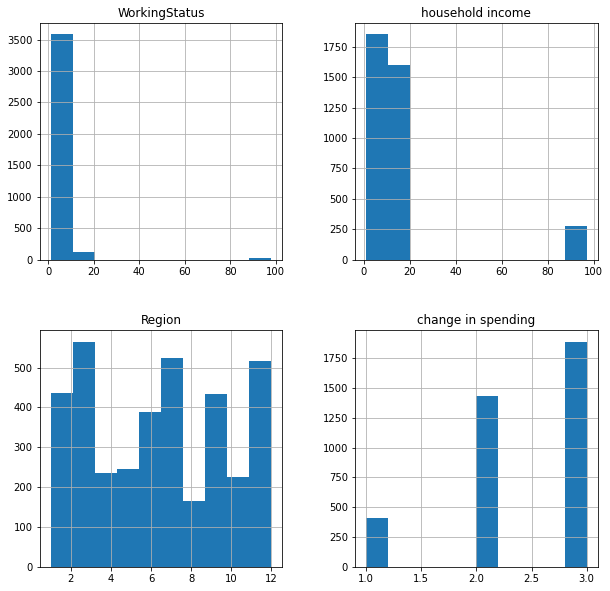

In [8]:
# Plotting Histogram to check the imbalance in data set.


no_null.hist(bins=10, figsize=(10,10))

In [9]:
# Counting the Values of categories for further balancing.

no_null['change in spending'].value_counts()

3.0    1888
2.0    1431
1.0     413
Name: change in spending, dtype: int64

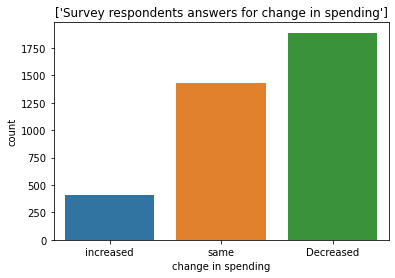

In [10]:
# Highlighting the imbalanced in response variable

highlight = sn.countplot(x=no_null['change in spending'])
highlight.set_xticklabels(['increased','same','Decreased'])
highlight.set_title(["Survey respondents answers for change in spending"])
plt.show()

In [11]:
# Resampling to have a balanced data set by using oversamling meathod


#creating two different dataframe of majority and minority class 
resample_1 = no_null[(no_null['change in spending']==1)] 
resample_2 = no_null[(no_null['change in spending']==2)] 
resample_3 = no_null[(no_null['change in spending']==3)] 

# upsampling minority class
unsampled_1 = resample(resample_1, 
              replace=True,    # sample with replacement
              n_samples= 1888, # to match majority class
              random_state=42)  # reproducible results

unsampled_2 = resample(resample_2, 
              replace=True,    # sample with replacement
              n_samples= 1888, # to match majority class
              random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
balanced_sample = pd.concat([resample_3, unsampled_1, unsampled_2])
balanced_sample

,WorkingStatus,household income,Region,change in spending
4999,2,10,8.0,3.0
5010,8,11,9.0,3.0
5011,3,10,6.0,3.0
5018,10,9,8.0,3.0
5031,5,11,1.0,3.0
...,...,...,...,...
16396,1,10,9.0,2.0
7640,5,15,4.0,2.0
11787,8,10,7.0,2.0
13701,1,12,5.0,2.0


<AxesSubplot:>

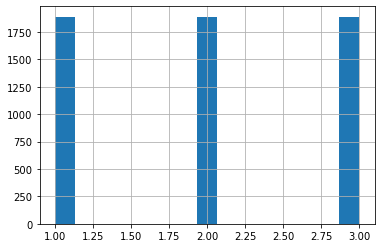

In [12]:
# Checking the balance sample again visually with histogram

balanced_sample['change in spending'].hist(bins=15)

In [13]:
# Summary Statistics of variables

summary = balanced_sample.describe()
summary

,WorkingStatus,household income,Region,change in spending
count,5664.000000,5664.000000,5664.000000,5664.000000
mean,4.803319,15.259534,6.316384,2.000000
std,8.861671,21.220879,3.250750,0.816569
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,9.000000,3.000000,1.000000
50%,2.000000,11.000000,6.000000,2.000000
75%,8.000000,13.000000,9.000000,3.000000
max,98.000000,97.000000,12.000000,3.000000


# Multivariate Classification 


In [14]:
# Creating Feature vector and Label Vector

x = np.array(balanced_sample.drop(['change in spending'],1))
y = np.array(balanced_sample['change in spending'])
x, y

(array([[ 2., 10.,  8.],
        [ 8., 11.,  9.],
        [ 3., 10.,  6.],
        ...,
        [ 8., 10.,  7.],
        [ 1., 12.,  5.],
        [ 8., 13.,  9.]]),
 array([3., 3., 3., ..., 2., 2., 2.]))

# 1) K Nearest Neighbor

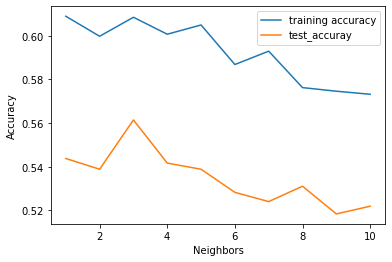

In [15]:
# Creating train and test samples with default 80-20 ratio.

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

# KNN

# empty sets for recording the results
training_accuracy = []
test_accuracy = []

#trying n_neighbors from 1 to 10
neighbors_settings = range(1,11)

for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_train,y_train)
    training_accuracy.append(knn.score(x_train,y_train))
    test_accuracy.append(knn.score(x_test,y_test))
    
# Plotting the training and test results for 1 to 10 Neighbors
plt.plot(neighbors_settings,training_accuracy,label='training accuracy')
plt.plot(neighbors_settings,test_accuracy,label='test_accuray')
plt.ylabel ("Accuracy")
plt.xlabel ("Neighbors")
plt.legend()

# Seems the model performs best with 3 neighbors.

In [16]:
# Calculating the Accuracy Score for trainiing and test models with 3 Neighbors

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
knn_3 = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski') # metric distancing with manhattan also gives same results
knn_3.fit (x_train,y_train)
print('Accuracy on training set: {:.3f}'.format(knn_3.score(x_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(knn_3.score(x_test,y_test)))

Accuracy on training set: 0.609
Accuracy on test set: 0.561


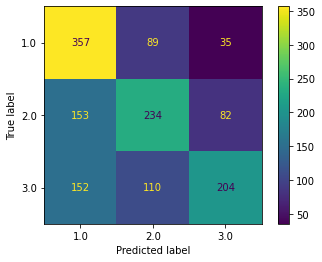

In [17]:
#Confusion matrix

y_pred = knn_3.predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_pred, labels=knn_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=knn_3.classes_)
disp.plot()
plt.show()

In [18]:
# F1 scorel

f1_knn_3 = f1_score(y_test, y_pred, average=None)
f1_knn_3

array([0.62467192, 0.51884701, 0.5184244 ])

# 2) Gaussian Naive Bayes 

In [19]:
# Gaussian Naive Bayes

gnb = GaussianNB()
y_pred1 = gnb.fit(x_train, y_train).predict(x_test)

accuracy_score(y_test, y_pred1)

0.355225988700565

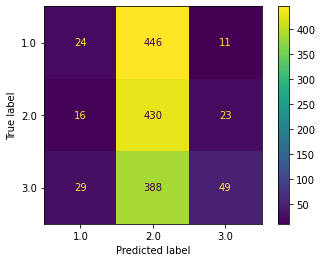

In [20]:
#Confusion matrix

cnf_matrix = confusion_matrix(y_test, y_pred1, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=knn_3.classes_)
disp.plot()
plt.show()

This model is predicting most of the observations as class = 2, thus not performing well and aslo the accuracy score is less than KNN model.

# 3) Decission Tree

In [21]:
# Decission Tree 

dtc = DecisionTreeClassifier(random_state=0)


dtc.fit(x_train,y_train)
print(dtc.score(x_train,y_train))
print(dtc.score(x_test,y_test))

# This model performs little better than KNN

0.6734934086629002
0.5798022598870056


Feature importance:
[0.26065757 0.32015458 0.41918785]


<AxesSubplot:>

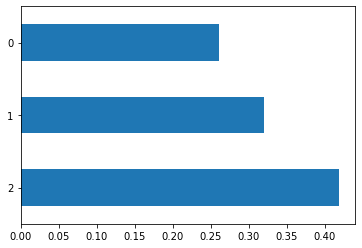

In [22]:
# Feature importance
print("Feature importance:\n{}".format(dtc.feature_importances_))

(pd.Series(dtc.feature_importances_)
   .nlargest(4)
   .plot(kind='barh'))

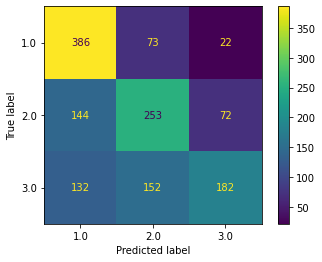

In [23]:
#Confusion matrix

y_pred2= dtc.fit(x_train, y_train).predict(x_test)
cnf_matrix = confusion_matrix(y_test, y_pred2, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=knn_3.classes_)
disp.plot()
plt.show()

In [24]:
f1_dtc = f1_score(y_test, y_pred2, average=None)
f1_dtc

array([0.67541557, 0.5343189 , 0.49056604])

After comparing the results from all 3 algorithms, Decission tree seems to be performing the best with 67% accuracy on training sample and 58% accuracy on test sample. Whereas KNN is also predicting similar results with 61% accuracy in training sample and 56% in test sample. Thus for the prediction of A person likely to spend less, more or same based on above disscused factors, Decission tree seems be the most accurate model out of 3. 

Please note, Due to many missing values and very less corrresponding data, many other relevant features have been missed out and the prediction model could also be made more accurate given a more balanced dataset. 

# Finalizing the best perforing model

In [25]:
model_pkl = open('predictive_model.pkl', 'wb')
pickle.dump(dtc,model_pkl )
model_pkl.close()

# Making prediction 

For a person working part time under 8 hours per week, having income between 9500 and 11499, and living in West Midlands.


In [26]:
# load the model from disk

change_in_spending_model = pickle.load(open('predictive_model.pkl','rb'))
change_in_spending_model.predict([[3,5,6]])

array([3.])

This person is likely to decrease his/her expenditure when there is a sudden change in his/her income. 